# Linear Regression with computational graphs
## Get a dataset

In [1]:
import random
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

Define the path to the file containing the CSV data and read the data using Pandas.

In [2]:
datafile = "lausanne-appart.csv"
dataset = pd.read_csv(datafile)
dataset.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


In [3]:
rent_price = dataset.rent_price.values
living_area = dataset.living_area.values

## Visualize the data
Plot a scatter plot of renting price as a function of living area

In [4]:
def plot_data_prediction(x_points, y_points, x_curve = None, y_curve = None, x_title = 'x', y_title = 'y'):
    plt.title("{} as a function of {}".format(y_title, x_title))
    plt.xlabel(x_title)   # ex "Living area (m^2)"
    plt.ylabel(y_title)   # ex "Rent (CHF)"
    plt.scatter(x_points, y_points)
    if x_curve is not None and y_curve is not None:
        plt.plot(x_curve, y_curve, color="red")
    plt.legend(["data", "model"])
    plt.grid(True)
    plt.show()

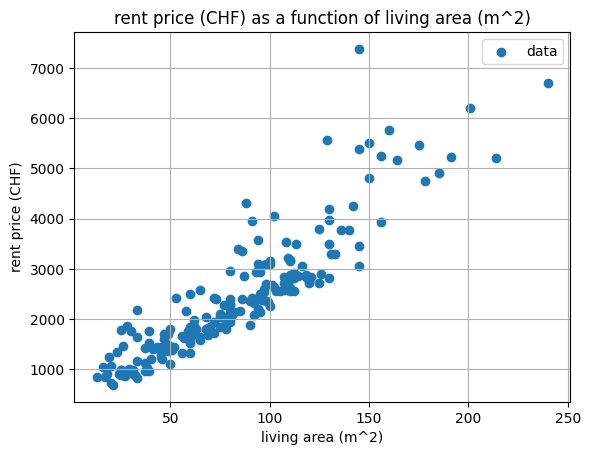

In [5]:
plot_data_prediction(living_area, rent_price, x_title='living area (m^2)', y_title='rent price (CHF)')

## Normal equations for linear regression
Closed form solution to this problem using the following normal equation: $\theta = (X^{T}X)^{-1}X^{T}\vec{y}$

intercept: 240.07710726596173
slope: 26.332424571995666


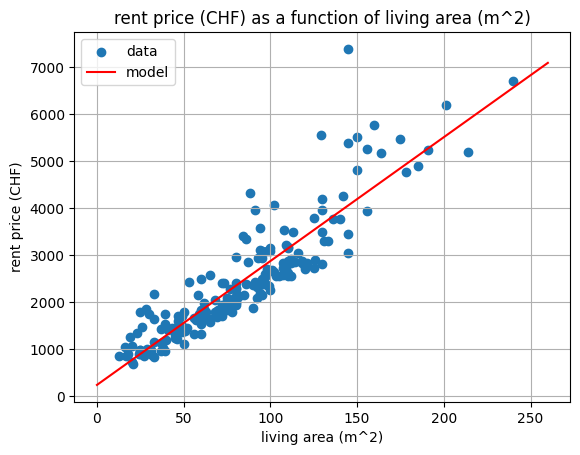

In [6]:
X = np.c_[np.ones(len(living_area)), living_area]
y = rent_price
theta = inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)

print("intercept:", theta[0])
print("slope:", theta[1])

x_curve = np.array(np.linspace(0, np.max(X) + 20, 200))
y_curve = theta[0] + theta[1] * x_curve

plot_data_prediction(living_area, rent_price, x_curve, y_curve, x_title='living area (m^2)', y_title='rent price (CHF)')

b) Compute the overall MSE loss with $J(\theta) = \frac{1}{2N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n})^{2} = \frac{1}{2N} \sum_{n=1}^{N} (\hat{y}_{n} - y_{n})^{2}$

In [7]:
def mse_loss(y_hat, y):
    diff = y - y_hat
    total = np.sum(np.square(diff))
    return total / (2 * len(y_hat))

y_hat = theta[0] + theta[1] * living_area
J = mse_loss(y_hat, y)
print("The total value of the loss is", J)

The total value of the loss is 138034.95779787414


## Stochastic gradient descent for linear regression with computational graph

### Graph creation

In [8]:
from cgnodes import *

In [9]:
### TO COMPLETE  - CREATE THE GRAPH ###
# first create all ValueNode objects
x = ValueNode()
theta_0 = ValueNode()
theta_1 = ValueNode()
y = ValueNode()
q = ValueNode()
y_hat = ValueNode()
j = ValueNode()
# then create all <Operator>Node objects
mult_node = MultiplyNode(in_nodes=[x, theta_1], out_node=q)
add_node = AddNode(in_nodes=[q, theta_0], out_node=y_hat)
mse_node = MSELossNode(in_nodes=[y_hat, y], out_node=j)

# finally build the graph by declaring inputs and outputs as 2 lists of ValueNode objects
cg = CompGraph([x, theta_0, theta_1, y], [j])

In [10]:
# try a forward pass with dummy values
cg.reset_values()
cg.forward([0.0, 0.0, 0.0, 1.0])
print(j.v)  # should give 0.5

0.5


In [11]:
cg.backward()
print(theta_0.grad_v, theta_1.grad_v)  # should give -1.0 -0.0

-1.0 -0.0


### Plain vanilla stochastic gradient descent

In [12]:
alpha = 0.0000001  # learning rate
itr = 100000
loss_step = 32
N = len(living_area)
t0 = 0.0   # initial value of theta_0
t1 = 0.0   # initial value of theta_1

loss_evolution = []
t0_evolution = []
t1_evolution = []
averaged_loss = 0.0

for i in range(itr):
    n = random.choice(range(0, N))  # random sampling in the training set
    cg.reset_values()
    cg.forward([living_area[n], t0, t1, rent_price[n]])
    cg.backward()
    t0 = t0 - alpha * theta_0.grad_v  # update rule for theta_0   TO COMPLETE
    t1 = t1 - alpha * theta_1.grad_v   # update rule for theta_1   TO COMPLETE
    t0_evolution.append(t0)
    t1_evolution.append(t1)
    averaged_loss += j.v
    if (i+1)%loss_step == 0:  # log the loss every loss_step
        loss_evolution.append(averaged_loss / loss_step)
        averaged_loss = 0.0

print(t0, t1)
y_hat = t0 + t1 * living_area
J = mse_loss(y_hat, rent_price)
print("The total value of the loss is", J)

0.7806005120535413 28.622327699618012
The total value of the loss is 144139.6814262281


In [13]:
def plot_training_log(loss_evolution, t0_evolution, t1_evolution, x, y):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,7))
    fig.suptitle('Training log')
    ax2.plot(loss_evolution)
    ax2.set_title('loss')
    ax1.plot(t0_evolution)
    ax1.set_title('theta 0')
    ax3.plot(t1_evolution)
    ax3.set_title('theta 1')
    ax4.scatter(x, y, s=1.0)
    x_curve = np.array(np.linspace(np.min(x), np.max(x), 2))
    y_curve = t0_evolution[-1] + t1_evolution[-1] * x_curve  # use last value of evolution as thetas
    ax4.plot(x_curve, y_curve, color='red')
    ax4.set_title('points and model output')
    fig.tight_layout()

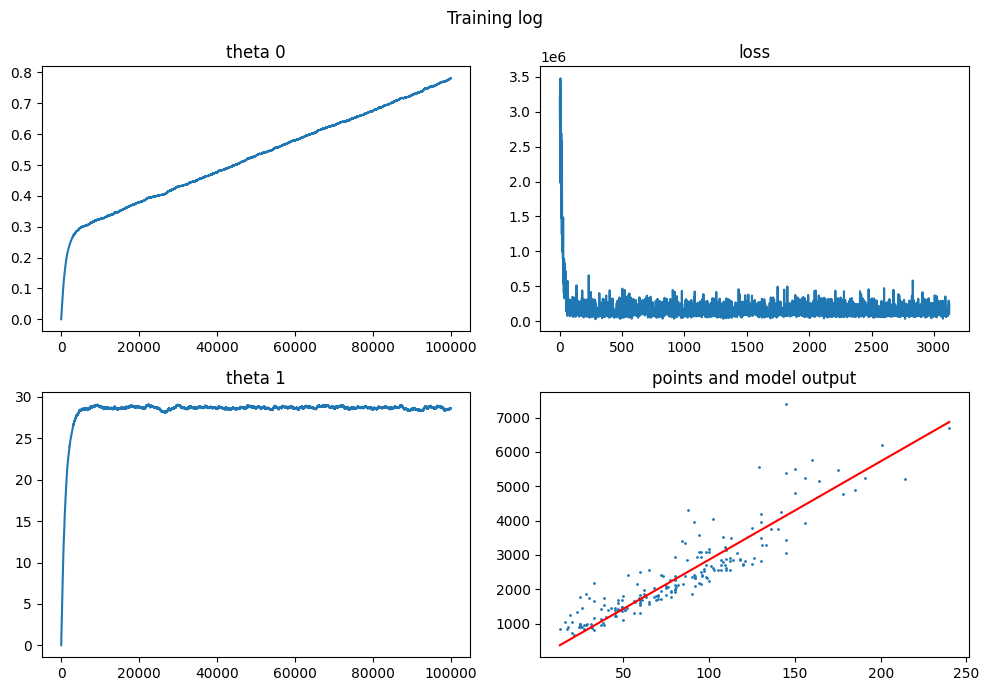

In [14]:
plot_training_log(loss_evolution, t0_evolution, t1_evolution, living_area, rent_price)

**Your observations**

- Evolution of the loss: Oscillates around the optimal value because of the random sampling
- Evolution of theta_1: Converge quickly because it has a big impact on the loss
- Evolution of theta_0: Will converge very slowly to the optimal value but it will with more iterations


## Implementation with mini-batch

0.34612759374813945 28.403224640922133
The total value of the loss is 144425.29883951772


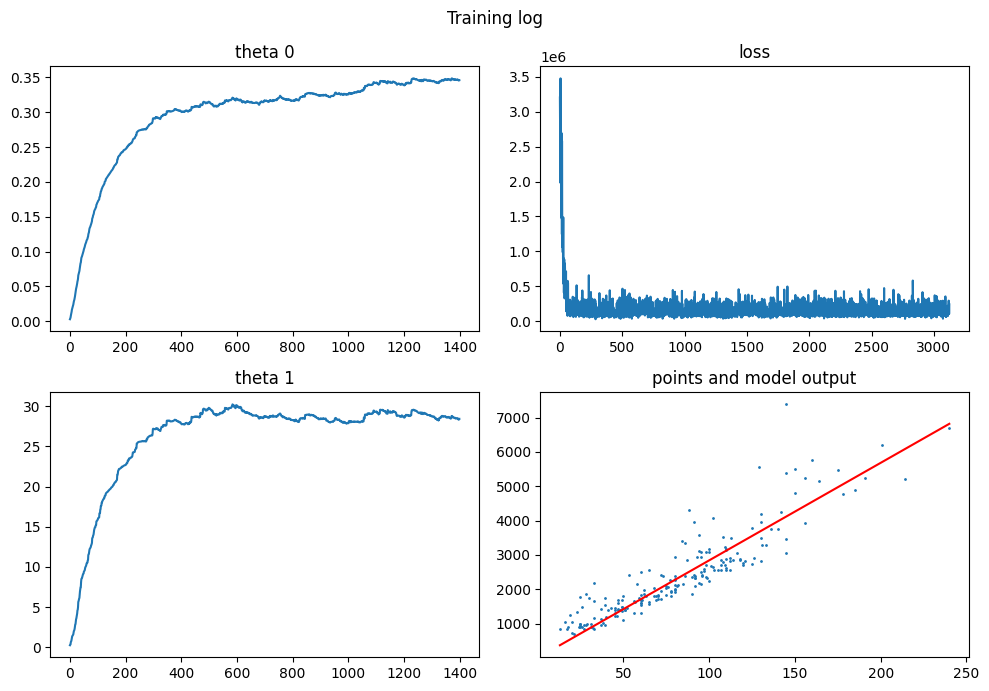

In [15]:
alpha = 0.000001  # learning rate
epochs = 200
batch_size = 32
N = len(living_area)
t0 = 0.0
t1 = 0.0

epoch_loss_evolution = []
batch_loss_evolution = []
t0_evolution = []
t1_evolution = []
epoch_loss = 0.0
batch_loss = 0.0

for epoch in range(epochs):
    n_steps = N // batch_size + 1  # the number of batches to make 1 epoch
    for step in range(n_steps):
        grad_theta_0 = 0.0
        grad_theta_1 = 0.0
        for i in range(batch_size):
            n = random.choice(range(0, N))  # random sampling in the training set
            cg.reset_values()
            # cg.forward([living_area[n], rent_price[n], t0, t1, -1.0, 0.5])
            cg.forward([living_area[n], t0, t1, rent_price[n]])
            cg.backward()
            grad_theta_0 += theta_0.grad_v
            grad_theta_1 += theta_1.grad_v
            batch_loss += j.v
        t0 = t0 - alpha * theta_0.grad_v   # update rule for theta_0   TO COMPLETE
        t1 = t1 - alpha * theta_1.grad_v   # update rule for theta_1   TO COMPLETE
        t0_evolution.append(t0)
        t1_evolution.append(t1)
        batch_loss_evolution.append(batch_loss / batch_size)
        epoch_loss += batch_loss
        batch_loss = 0.0
    epoch_loss_evolution.append(epoch_loss / n_steps)
    epoch_loss = 0.0

print(t0, t1)
y_hat = t0 + t1 * living_area
J = mse_loss(y_hat, rent_price)
print("The total value of the loss is", J)
plot_training_log(loss_evolution, t0_evolution, t1_evolution, living_area, rent_price)

**Your observations (comparison with the stochastic version)**

- Evolution of the loss: Oscillates around the optimal value because of the random sampling
- Evolution of theta_1: Converge quickly because it has a big impact on the loss
- Evolution of theta_0: Converges faster than the stochastic version because of the mini-batch


# Exercice 2

### a) Is it true to say that a linear regression is a very simple neural network ?
Yes it is since it has only one layer and no activation function.

### b) Write a text to explain the chain rule to your grandmother. You may ask Chat GPT to help you.

A function is a mathematical rule that takes an input (usually represented by x) and produces an output (usually represented by y). For example, f(x) = x^2 is a function that squares the input value of x and produces the output value of y.

The derivative of a function tells us how quickly the output value of the function changes when the input value is changed. For example, the derivative of f(x) = x^2 is f'(x) = 2x, which tells us that if we increase x by a small amount, the output value of y will increase twice as fast.

The chain rule is a way to find the derivative of a function that is made up of two or more simpler functions. It helps us understand how the changes in one part of the function affect the overall output of the function.

The chain rule is a very important concept in math and science, as it allows us to analyze and optimize complex systems by breaking them down into simpler parts and understanding how they interact with each other.

### c) What is the link between the chain rule and the principle of back propagation ?

The back propagation is the chain derivative (chain rule) in the computational graph.

### d) In computational graphs, we say that the "+" gate is a gradient distributor. Why ? How can we qualify the multiplication gate and the max gate ?

When we use the "+" gate with the back propagation, we distribute one value to multiple branches.
The multiplication gate is a gradient switcher and the max gate is a gradient router.

### e) Give 4 advantages of using computational graphs for learning strategies.

1. It is intuitive
2. We can easily add new nodes
3. Divide and conquer to easy understand the process.
4. The loss function is just a new node.